classification_distilbert_acc.py

In [ ]:
import torch
from datasets import Dataset
from evaluate import load as load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
import pandas as pd

# === GPU Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# === Load Dataset ===
csv_path = "Sentence_Classification_Dataset_updated.csv"
df = pd.read_csv(csv_path)
df = df.drop_duplicates(subset="sentence").reset_index(drop=True)

# === Define Generalized Labels ===
general_labels = ["Financial", "Technology", "ResearchAndDevelopment", "SocialResponsibility", "StrategicMoves"]

# === Validate Labels ===
if not set(df["label"]).issubset(set(general_labels)):
    raise ValueError(f"Unexpected label(s) found in dataset. Allowed labels: {general_labels}")

# === Split Data ===
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["sentence"], df["label"], test_size=0.4, random_state=42
)

# === Label Encoding ===
label2id = {label: idx for idx, label in enumerate(general_labels)}
id2label = {idx: label for label, idx in label2id.items()}
train_labels = [label2id[label] for label in train_labels]
test_labels = [label2id[label] for label in test_labels]

# === Tokenization ===
model_id = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_id)
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)

# === Prepare Dataset ===
train_dataset = Dataset.from_dict({**train_encodings, "labels": train_labels})
test_dataset = Dataset.from_dict({**test_encodings, "labels": test_labels})

# === Load Model ===
model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
).to(device)

# === Training Setup ===
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
#    evaluation_strategy="epoch",
)

# === Accuracy Metric ===
accuracy_metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

# === Trainer ===
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# === Train and Evaluate ===
trainer.train()
eval_results = trainer.evaluate()
print("\n===== Classification Benchmark =====")
print(f"Accuracy: {eval_results['eval_accuracy'] * 100:.2f}%")
print(f"Train size: {len(train_texts)}, Test size: {len(test_texts)}")
print(f"Overlap: {len(set(train_texts) & set(test_texts))}")

classification_bert_large_uncased_acc.py

In [ ]:
import torch
from datasets import Dataset
from evaluate import load as load_metric
from transformers import (
    AutoTokenizer,
    BertForSequenceClassification,
    BertConfig,
    TrainingArguments,
    Trainer,
)
from sklearn.model_selection import train_test_split
import pandas as pd

# === GPU Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# === Load and Clean Dataset ===
df = pd.read_csv("Sentence_Classification_Dataset_updated.csv")

# Drop duplicates to avoid data leakage
df = df.drop_duplicates(subset="sentence").reset_index(drop=True)

# === Define Generalized Labels ===
general_labels = ["Financial", "Technology", "ResearchAndDevelopment", "SocialResponsibility", "StrategicMoves"]

# Validate label consistency
if not set(df["label"]).issubset(set(general_labels)):
    raise ValueError(f"Unexpected label(s) found in dataset. Allowed labels: {general_labels}")

# === Train/Test Split ===
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["sentence"], df["label"], test_size=0.4, random_state=42
)

# === Label Encoding ===
label2id = {label: idx for idx, label in enumerate(general_labels)}
id2label = {idx: label for label, idx in label2id.items()}
train_labels = [label2id[label] for label in train_labels]
test_labels = [label2id[label] for label in test_labels]

# === Tokenization ===
model_id = "bert-large-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_id)
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)

# === Prepare Dataset ===
train_dataset = Dataset.from_dict({**train_encodings, "labels": train_labels})
test_dataset = Dataset.from_dict({**test_encodings, "labels": test_labels})

# === Load Model with Config ===
config = BertConfig.from_pretrained(
    model_id,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id,
)

model = BertForSequenceClassification.from_pretrained(
    model_id,
    config=config
).to(device)

# === Training Setup ===
training_args = TrainingArguments(
    output_dir="./results_roberta",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs_roberta",
)

# === Accuracy Metric ===
accuracy_metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

# === Trainer ===
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# === Train and Evaluate ===
trainer.train()
eval_results = trainer.evaluate()
print("\n===== Classification Benchmark =====")
print(f"Accuracy: {eval_results['eval_accuracy'] * 100:.2f}%")

# === Overlap Check (Optional Debugging)
print(f"Train size: {len(train_texts)}, Test size: {len(test_texts)}")
print(f"Overlap: {len(set(train_texts) & set(test_texts))}")

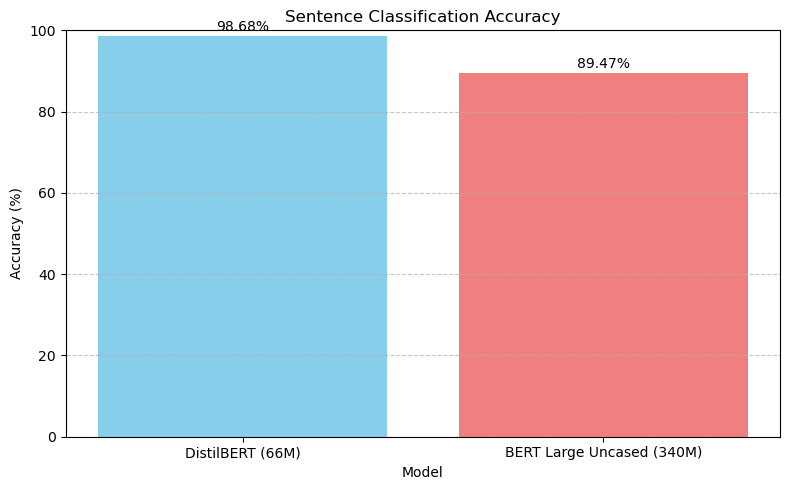

In [5]:
import matplotlib.pyplot as plt

# === Accuracy Results ===
model_names = ["DistilBERT (66M)", "BERT Large Uncased (340M)"]
accuracies = [98.68, 89.47]

# === Create Bar Plot ===
plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, accuracies, color=["skyblue", "lightcoral"])
plt.ylim(0, 100)

# Annotate bars with accuracy values
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f"{acc:.2f}%", ha='center', va='bottom')

plt.title("Sentence Classification Accuracy")
plt.xlabel("Model")
plt.ylabel("Accuracy (%)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


Both of these encoder-based models were tested on a 60/40 training-testing split, in order to challenge them while utilizing a small dataset. I also modified the supplied dataset with labels that accurately categorize its data for training and testing. I found that DistilBERT, as well as BERT Large Uncased, were both highly accurate when it came categorizing sentences. 

However, DistilBERT was found to be slightly more accurate than BERT Large Uncased, even though DistilBERT was made up of less than a fifth of the parameters of BERT Large Uncased. 

This is likely due to DistilBERT's smaller transformer architecture allowing it to adjust to a small dataset more effectively than BERT Large Uncased. 

The larger model would likely need further finetuning, as its large amount of parameters would allow the model a significantly more accurate performance with a larger dataset, rather than a smaller one.